In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.integrate as integrate
from scipy.integrate import simps
import os

Our goal is to calculate the approximated number of neutron-induces nuclear recoils when placing our sample next to some spontaneous fission source, most likely 252 Cf at 1mCurie. We are using the Watt Spectrum to determine the differential flux spectrum for 252 Cf and multiplying it by the number of expected neutrons coming from 252 Cf to find dphi/dEn.


Watt Spectrum: 𝛷(𝐸𝑛) = 𝐶𝑒−(𝑎𝐸𝑛)sinh⁡√𝑏𝐸𝑛

### Solving for the $\frac{d\phi}{dE}$ term.

In [4]:
#determining the normalization value C for the Watt spectrum

a = 0.84
b = 1.03

def watt_spectrum_norm(En, a, b):
    return np.exp(-a * En) * np.sinh(np.sqrt(b * En))

# Perform the integration over [0, infinity]
integral_value, error = integrate.quad(watt_spectrum_norm, 0, np.inf, args=(a, b))

# Compute the constant C
C = 1 / integral_value

# Output the result
print(f"Normalization constant C: {C:.3f}")

Normalization constant C: 0.630


In [5]:
#finding the normalization factor forthe watt spectrum
C = 1 / integral_value
def watt_spectrum(E_n):
    return C * np.exp(-a * E_n) * np.sinh(np.sqrt(b * E_n))


def solid_angle_part(theta, dtheta, dphi, r):
    return (np.sin(theta) * dtheta * dphi) / (4 * np.pi * ((r)**2))


#just calling E_n 0 for now so it doesn't error out, we can set up the integral later once we determine the range of E values we want to look at

num_neutron_252Cf = 2.34e12 #number of expected induced nuclear recoils from 252Cf sample just sitting there

d_watt_spectrum_ex = watt_spectrum(0) * num_neutron_252Cf #now we have the un-normalized watt spectrum ready for integration term down below

The integral value from 0.1 MeV to 10 MeV is 0.98451, where these MeV values correspond to the initial energy of the neutrons.


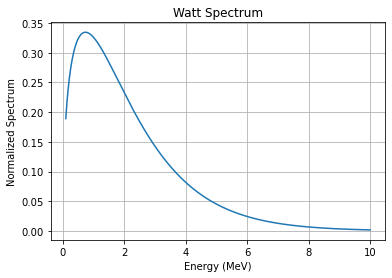

In [6]:
E_n_range = np.linspace(0.1,10,1000)
watt_values = []

for i in E_n_range:
  watt_val = watt_spectrum(i)
  watt_values.append(watt_val)

plt.plot(E_n_range, watt_values)
plt.title("Watt Spectrum")
plt.xlabel("Energy (MeV)")
plt.ylabel("Normalized Spectrum")
plt.grid(True)

integral_value, error = integrate.quad(watt_spectrum, 0.1, 10)
print(f"The integral value from 0.1 MeV to 10 MeV is {integral_value:.5f}, where these MeV values correspond to the initial energy of the neutrons.")
#note this is only assuming a single collision

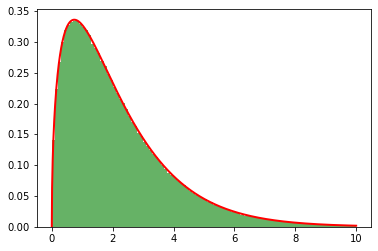

In [7]:
A=56/1
def pdf(x):
    return (1 / 1.58) * np.exp(-0.84 * x) * np.sinh(np.sqrt(1.03 * x))

# Define the intervals
intervals = np.arange(0, 10.1, 0.1)  # 0 to 10 with step 0.1
midpoints = (intervals[:-1] + intervals[1:]) / 2  # Midpoints of intervals

# Calculate the probability for each interval
probabilities = pdf(midpoints) * 0.1  # Approximate the integral over each interval
probabilities /= np.sum(probabilities)  # Normalize to sum to 1
cdf = np.cumsum(probabilities)

def rng_sample(size=1):
    uniform_randoms = np.random.uniform(0, 1, size)
    samples = np.searchsorted(cdf, uniform_randoms)
    return intervals[samples]  # Map the indices back to the corresponding interval start points

# Generate samples
samples = rng_sample(size=1000000)

bin_heights, bin_edges, _ = plt.hist(samples, bins=intervals, density=True, alpha=0.6, color='g')

#find areas of defined rectangles
bins_as_ranges = list(zip(bin_edges[:-1], bin_edges[1:]))
rectangles = [{'range': r, 'height': h} for r, h in zip(bins_as_ranges, bin_heights)]
areas = [(rect['height'] * (rect['range'][1] - rect['range'][0])) for rect in rectangles]

# Normalize the areas to create a probability distribution
total_area = np.sum(areas)
probabilities = [area / total_area for area in areas]  #checked this sums to 1 for all values which is good

# Compute the CDF (cumulative distribution function)
cdf = np.cumsum(probabilities)


# Plot the actual PDF for comparison
x_vals = np.linspace(0, 10, 1000)
plt.plot(x_vals, pdf(x_vals), 'r-', lw=2)
plt.show()

# Weighted E spectrum values according to the watt spectrum.

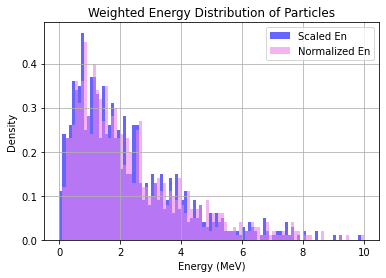

In [8]:
def weighted_rng_sample(size=1):
    uniform_randoms = np.random.uniform(0, 1, size)  # Generate uniform randoms in range [0, 1]
    samples = np.searchsorted(cdf, uniform_randoms)  # Find corresponding bins based on CDF
    energy_values = [np.random.uniform(rectangles[i]['range'][0], rectangles[i]['range'][1]) for i in samples]
    return np.array(energy_values)

num_particles = 1000
En = weighted_rng_sample(size=num_particles)

min_val, max_val = 0.1, 10
min_En = np.min(En)
max_En = np.max(En)
normalized_En = min_val + (En - min_En) * (max_val - min_val) / (max_En - min_En) #normalizing spectrum over 0.1 to 10 MeV range


# For verification, plot the histogram of the generated energy values
plt.hist(En, bins=intervals, density=True, alpha=0.6, color='b', label = 'Scaled En')
plt.hist(normalized_En, bins=intervals, density=True, alpha=0.6, color='violet', label = 'Normalized En')
plt.title("Weighted Energy Distribution of Particles")
plt.xlabel("Energy (MeV)")
plt.ylabel("Density")
plt.legend(loc = 'best')
plt.grid(True)

# Dealing with number of secondary recoils - dummy test:

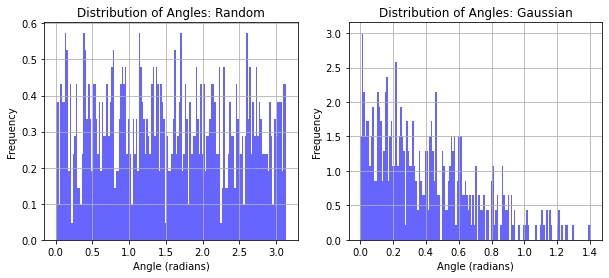

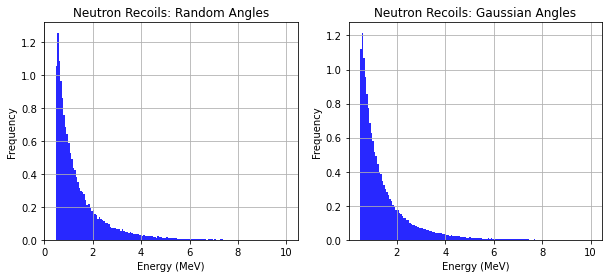

In [9]:
#dummy test that keeps looping over a particle until it no longer has enough energy to recoil again

def energy_transfer(En,theta):
    y = np.abs( (1 - ( (A**2 + 1 + 2*A*np.cos(theta) ) / ((A + 1)**2) ) ) * En)
    y_new = En - y
    return(y_new) #taking into account the energy lost from a neutron hitting another particle and then subtracting that lost energy from the now current neutron

num_angles = 1000 #number of angles within the range 0 to pi (0 degrees to 180 degrees) to loop over - want to get a good spectrum

#dummy test for random distribution of angles in 0 to pi radians (so it stays only in positive)
angles_random = np.random.uniform(0, np.pi, num_angles)

#creating gaussian distribution of values from 0 to pi radians
mean = 0
std_dev = 0.5 #come up with a motivation for what the std is
gaussian_random = np.random.normal(mean, std_dev, num_angles)
angles_gauss = gaussian_random[(gaussian_random >= 0) & (gaussian_random <= np.pi)]

#creating most accurate scattering angle distribution based on the angle weights
#to be figured out later on

fig, axes = plt.subplots(1,2, figsize=(10,4)) #creating subplots to visualize the angular distributions easily
num_bins = 150

axes[0].hist(angles_random, bins = num_bins,  density=True, alpha=0.6, color='b')
axes[0].set_title("Distribution of Angles: Random")
axes[0].set_xlabel("Angle (radians)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

axes[1].hist(angles_gauss, bins = num_bins,  density=True, alpha=0.6, color='b')
axes[1].set_title("Distribution of Angles: Gaussian")
axes[1].set_xlabel("Angle (radians)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

neutron_new_dummy = [] #appending for the dummy angular spectrum
neutron_new_gauss = [] #appending for the gauss angular spectrum

for i in normalized_En:
    while i > 0.5:
        theta = np.random.choice(angles_random)
        i = energy_transfer(i, theta)
        neutron_new_dummy.append(i)

for i in normalized_En:
    while i > 0.5:
        theta = np.random.choice(angles_gauss)
        i = energy_transfer(i, theta)
        neutron_new_gauss.append(i)

fig, axes = plt.subplots(1,2, figsize=(10,4)) #creating subplots to visualize the angular distributions easily
num_bins = 150

dummy_hist, dummy_bins, _ = axes[0].hist(neutron_new_dummy, bins=num_bins, density=True, alpha=0.6, color='b')
gauss_hist, gauss_bins, _ = axes[1].hist(neutron_new_gauss, bins=num_bins, density=True, alpha=0.6, color='b')


axes[0].hist(neutron_new_dummy, bins = num_bins, density=True, alpha=0.6, color='b')
axes[0].set_title("Neutron Recoils: Random Angles")
axes[0].set_xlabel("Energy (MeV)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

axes[1].hist(neutron_new_gauss, bins = num_bins, density=True, alpha=0.6, color='b')
axes[1].set_title("Neutron Recoils: Gaussian Angles")
axes[1].set_xlabel("Energy (MeV)")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)


# Importing and loading TALYS information.

In [10]:
#displaying an example .L00 csv
loo_o = pd.read_csv('/Users/katieream/Desktop/spitzgroup/talys/bin/252cf-neutron/o/008016_L00_data.csv', sep = ',')
loo_o

loo_si = pd.read_csv('/Users/katieream/Desktop/spitzgroup/talys/bin/252cf-neutron/si/014028_L00_data.csv', sep = ',')
loo_si

loo_mg = pd.read_csv('/Users/katieream/Desktop/spitzgroup/talys/bin/252cf-neutron/mg/012024_L00_data.csv', sep = ',')
loo_mg

loo_fe = pd.read_csv('/Users/katieream/Desktop/spitzgroup/talys/bin/252cf-neutron/fe/026056_L00_data.csv', sep = ',')
loo_fe

,Angle [deg],xs [mb/sr],Direct [mb/sr],Compound [mb/sr],E-in [MeV],loop number
0,0.0,2680.01800,2678.0600,1.957755,7.0,0
1,2.0,2665.89000,2663.9400,1.950006,7.0,0
2,4.0,2623.91700,2621.9900,1.927009,7.0,0
3,6.0,2555.31900,2553.4300,1.889507,7.0,0
4,8.0,2462.05900,2460.2200,1.838694,7.0,0
...,...,...,...,...,...,...
9004,172.0,33.92264,33.0437,0.878939,9.1,97
9005,174.0,35.19325,34.2861,0.907149,9.1,97
9006,176.0,36.13129,35.2032,0.928093,9.1,97
9007,178.0,36.70658,35.7656,0.940987,9.1,97


In [11]:
bigboy_df_o = []  #combining all talys files for oxygen
bigboy_df_si = [] #combining all talys files for silicon
bigboy_df_fe = [] #combining all talys files for iron
bigboy_df_mg = [] #combining all talys files for magnesium

O = '008016'  # oxygen identifier
Si = '014028' #silicon identifier
Mg = '012024' #magnesium identifier
Fe = '026056'  # iron identifier

### OXYGEN ###
directory = '/Users/katieream/Desktop/spitzgroup/talys/bin/252cf-neutron/o'
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        if filename.startswith(f"rec{O}"):
            file_path = os.path.join(directory, filename)
            
            csv_data = pd.read_csv(file_path, sep = '\t')
            part_with_number = filename.split('spec')[1]  # Isolate the part of the filename with the energy number
            energy_init = float(part_with_number.split('.')[0] + '.' + part_with_number.split('.')[1])
            
            csv_data['E-in [MeV]'] = energy_init
            bigboy_df_o.append(csv_data)
        
combined_df_o = pd.concat(bigboy_df_o)
E_initial_unique_o = sorted(combined_df_o['E-in [MeV]'].unique()) #starts at 4 MeV



### SILICON ###
directory = '/Users/katieream/Desktop/spitzgroup/talys/bin/252cf-neutron/si'
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        if filename.startswith(f"rec{Si}"):
            file_path = os.path.join(directory, filename)
            
            csv_data = pd.read_csv(file_path, sep = '\t')
            part_with_number = filename.split('spec')[1]  # Isolate the part of the filename with the energy number
            energy_init = float(part_with_number.split('.')[0] + '.' + part_with_number.split('.')[1])
            
            csv_data['E-in [MeV]'] = energy_init
            bigboy_df_si.append(csv_data)

combined_df_si = pd.concat(bigboy_df_si)
E_initial_unique_si = sorted(combined_df_si['E-in [MeV]'].unique()) #starts at 1.2 MeV


### MAGNESIUM ###
directory = '/Users/katieream/Desktop/spitzgroup/talys/bin/252cf-neutron/mg'
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        if filename.startswith(f"rec{Mg}"):
            file_path = os.path.join(directory, filename)
            
            csv_data = pd.read_csv(file_path, sep = '\t')
            part_with_number = filename.split('spec')[1]  # Isolate the part of the filename with the energy number
            energy_init = float(part_with_number.split('.')[0] + '.' + part_with_number.split('.')[1])
            
            csv_data['E-in [MeV]'] = energy_init
            bigboy_df_mg.append(csv_data)

combined_df_mg = pd.concat(bigboy_df_mg)
E_initial_unique_mg = sorted(combined_df_mg['E-in [MeV]'].unique()) #starts at 1.5 MeV


### IRON ###
directory = '/Users/katieream/Desktop/spitzgroup/talys/bin/252cf-neutron/fe'
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        if filename.startswith(f"rec{Fe}"):
            file_path = os.path.join(directory, filename)
            
            csv_data = pd.read_csv(file_path, sep = '\t')
            part_with_number = filename.split('spec')[1]  # Isolate the part of the filename with the energy number
            energy_init = float(part_with_number.split('.')[0] + '.' + part_with_number.split('.')[1])
            
            csv_data['E-in [MeV]'] = energy_init
            bigboy_df_fe.append(csv_data)

combined_df_fe = pd.concat(bigboy_df_fe)
E_initial_unique_fe = sorted(combined_df_fe['E-in [MeV]'].unique()) #starts at 0.5 MeV


combined_df_fe

,E-out [MeV],xs [mb/MeV],E-in [MeV]
0,0.004643,77790.590,2.8
1,0.013929,54875.530,2.8
2,0.023215,36697.910,2.8
3,0.032501,25432.020,2.8
4,0.041788,18892.270,2.8
...,...,...,...
16,0.082057,23147.650,1.5
17,0.087030,27771.510,1.5
18,0.092003,28715.480,1.5
19,0.096976,20459.690,1.5


# Seeing the differential cross section distributions for each target nuclei.

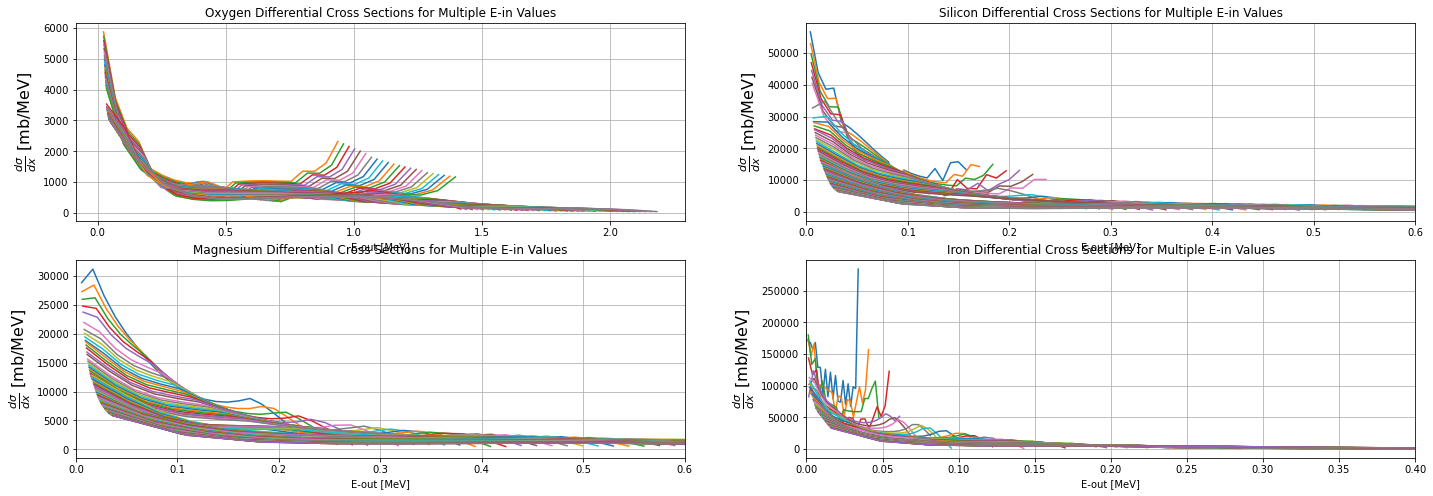

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(24, 8))

for e in E_initial_unique_o:
    filtered_df = combined_df_o[combined_df_o['E-in [MeV]'] == e]
    axes[0,0].plot(filtered_df['E-out [MeV]'], filtered_df[' xs [mb/MeV]'], label=f'E-in [MeV] = {e}')

axes[0,0].set_xlabel('E-out [MeV]', fontsize=10)
axes[0,0].set_ylabel(r'$\frac{d\sigma}{dx}$ [mb/MeV]', fontsize=16)
axes[0,0].set_title('Oxygen Differential Cross Sections for Multiple E-in Values')
axes[0,0].grid(True)
#plt.legend(loc='best')

for e in E_initial_unique_si:
    filtered_df = combined_df_si[combined_df_si['E-in [MeV]'] == e]
    axes[0,1].plot(filtered_df['E-out [MeV]'], filtered_df[' xs [mb/MeV]'], label=f'E-in [MeV] = {e}')

axes[0,1].set_xlabel('E-out [MeV]', fontsize=10)
axes[0,1].set_xlim(-0.0001, 0.6)
axes[0,1].set_ylabel(r'$\frac{d\sigma}{dx}$ [mb/MeV]', fontsize=16)
axes[0,1].set_title('Silicon Differential Cross Sections for Multiple E-in Values')
axes[0,1].grid(True)

for e in E_initial_unique_mg:
    filtered_df = combined_df_mg[combined_df_mg['E-in [MeV]'] == e]
    axes[1,0].plot(filtered_df['E-out [MeV]'], filtered_df[' xs [mb/MeV]'], label=f'E-in [MeV] = {e}')

axes[1,0].set_xlabel('E-out [MeV]', fontsize=10)
axes[1,0].set_xlim(-0.0001, 0.6)
axes[1,0].set_ylabel(r'$\frac{d\sigma}{dx}$ [mb/MeV]', fontsize=16)
axes[1,0].set_title('Magnesium Differential Cross Sections for Multiple E-in Values')
axes[1,0].grid(True)

for e in E_initial_unique_fe:
    filtered_df = combined_df_fe[combined_df_fe['E-in [MeV]'] == e]
    axes[1,1].plot(filtered_df['E-out [MeV]'], filtered_df[' xs [mb/MeV]'], label=f'E-in [MeV] = {e}')

axes[1,1].set_xlabel('E-out [MeV]', fontsize=10)
axes[1,1].set_xlim(-0.0001, 0.4)
axes[1,1].set_ylabel(r'$\frac{d\sigma}{dx}$ [mb/MeV]', fontsize=16)
axes[1,1].set_title('Iron Differential Cross Sections for Multiple E-in Values')
axes[1,1].grid(True)

plt.show()

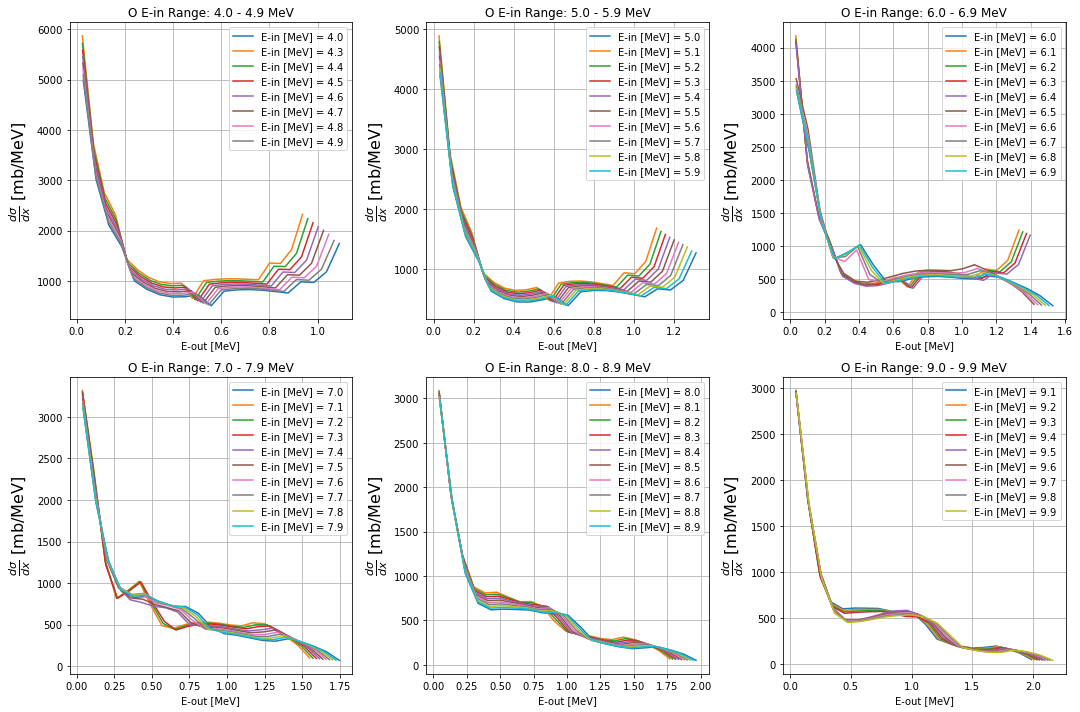

In [13]:
min_energy = min(E_initial_unique_o)
max_energy = max(E_initial_unique_o)

bins = np.arange(min_energy, max_energy + 1, 1)  #generating bins over proper range to cover the initial energy

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  

for i, ax in enumerate(axes):
    if i >= len(bins) - 1:
        ax.axis('off')  
        continue

    start_bin = bins[i]
    end_bin = bins[i + 1]
    
    current_chunk = [e for e in E_initial_unique_o if start_bin <= e < end_bin] #getting data in correct energy ranges
    for e in current_chunk:
        filtered_df = combined_df_o[combined_df_o['E-in [MeV]'] == e]
        ax.plot(filtered_df['E-out [MeV]'], filtered_df[' xs [mb/MeV]'], label=f'E-in [MeV] = {e}')
    
    ax.set_xlabel('E-out [MeV]', fontsize=10)
    ax.set_ylabel(r'$\frac{d\sigma}{dx}$ [mb/MeV]', fontsize=16)
    ax.set_title(f'O E-in Range: {start_bin} - {end_bin - 0.1} MeV')
    ax.grid(True)
    ax.legend(loc='best')


plt.tight_layout()
plt.show()

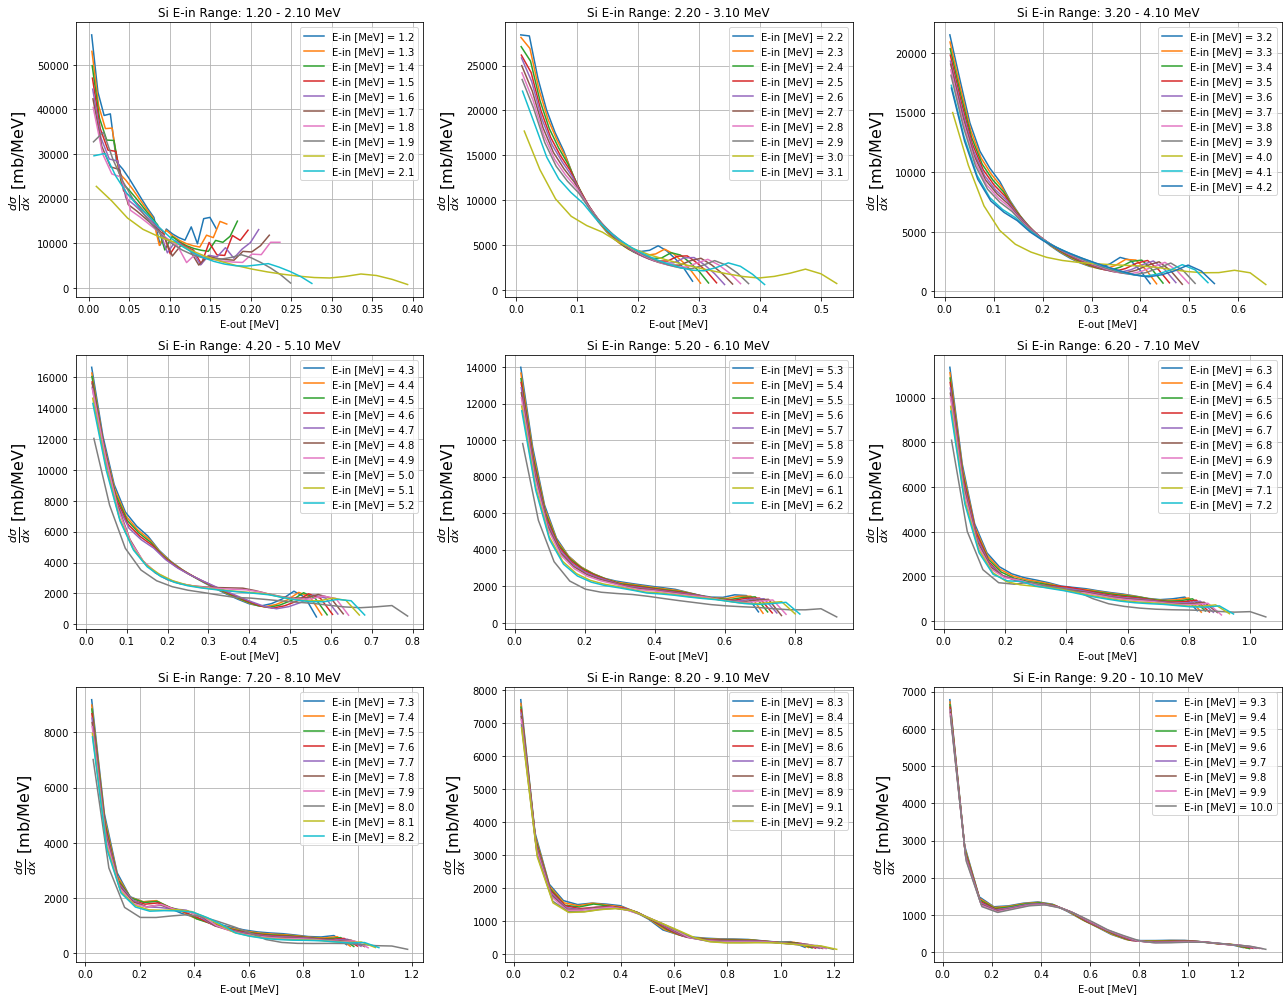

In [14]:
min_energy = min(E_initial_unique_si)
max_energy = max(E_initial_unique_si)

bins = np.arange(min_energy, max_energy + 1, 1)  #generating bins over proper range to cover the initial energy

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))
axes = axes.flatten()  

for i, ax in enumerate(axes):
    if i >= len(bins) - 1:
        ax.axis('off')  
        continue

    start_bin = bins[i]
    end_bin = bins[i + 1]
    
    current_chunk = [e for e in E_initial_unique_si if start_bin <= e < end_bin] #getting data in correct energy ranges
    for e in current_chunk:
        filtered_df = combined_df_si[combined_df_si['E-in [MeV]'] == e]
        ax.plot(filtered_df['E-out [MeV]'], filtered_df[' xs [mb/MeV]'], label=f'E-in [MeV] = {e}')
    
    ax.set_xlabel('E-out [MeV]', fontsize=10)
    ax.set_ylabel(r'$\frac{d\sigma}{dx}$ [mb/MeV]', fontsize=16)
    ax.set_title(f'Si E-in Range: {start_bin:.2f} - {(end_bin - 0.1):.2f} MeV')
    ax.grid(True)
    ax.legend(loc='best')


plt.tight_layout()
plt.show()

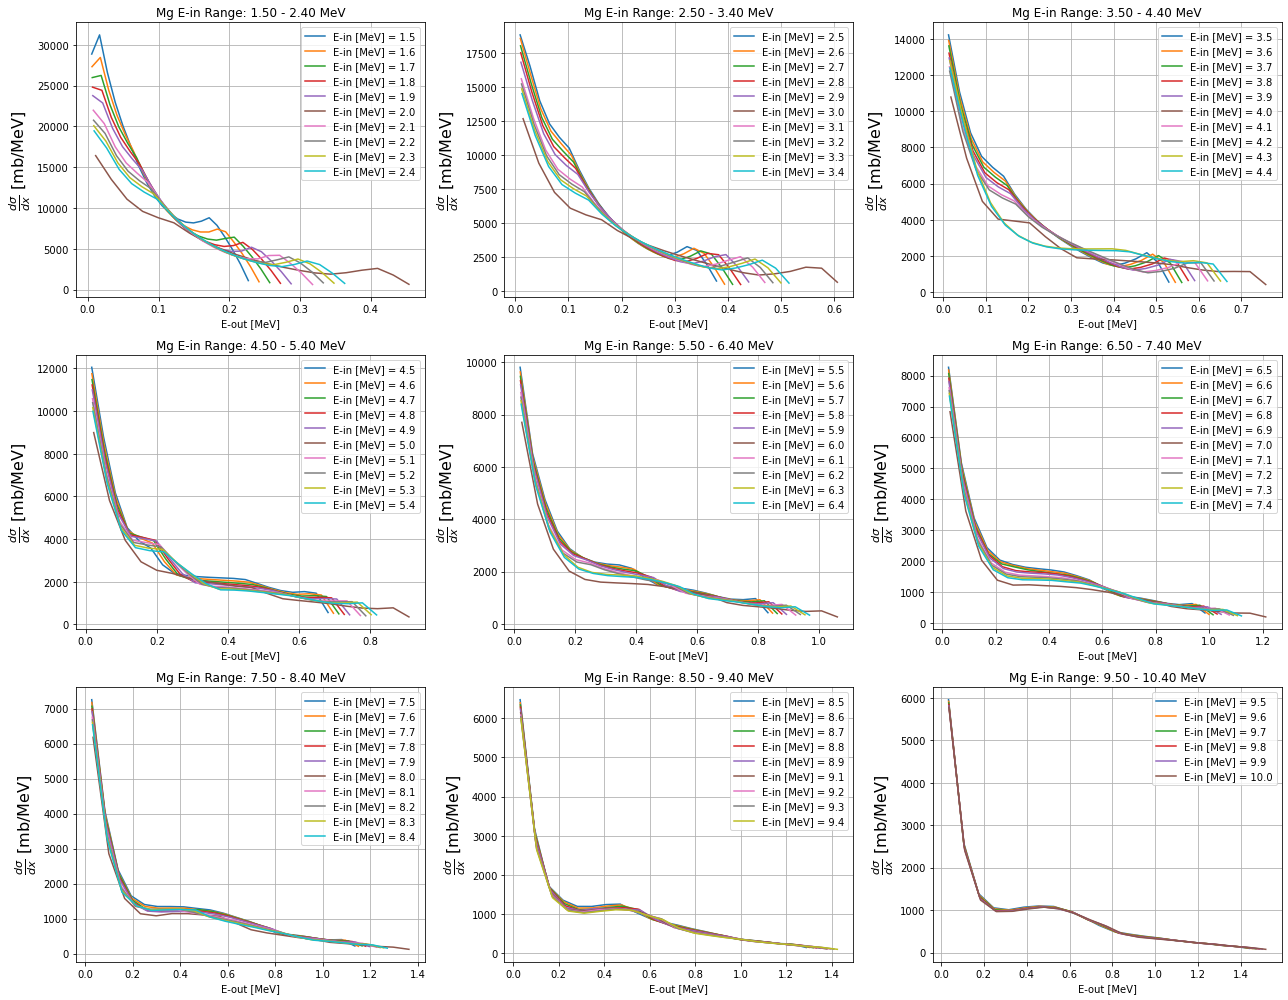

In [15]:
min_energy = min(E_initial_unique_mg)
max_energy = max(E_initial_unique_mg)

bins = np.arange(min_energy, max_energy + 1, 1)  #generating bins over proper range to cover the initial energy

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))
axes = axes.flatten()  

for i, ax in enumerate(axes):
    if i >= len(bins) - 1:
        ax.axis('off')  
        continue

    start_bin = bins[i]
    end_bin = bins[i + 1]
    
    current_chunk = [e for e in E_initial_unique_mg if start_bin <= e < end_bin] #getting data in correct energy ranges
    for e in current_chunk:
        filtered_df = combined_df_mg[combined_df_mg['E-in [MeV]'] == e]
        ax.plot(filtered_df['E-out [MeV]'], filtered_df[' xs [mb/MeV]'], label=f'E-in [MeV] = {e}')
    
    ax.set_xlabel('E-out [MeV]', fontsize=10)
    ax.set_ylabel(r'$\frac{d\sigma}{dx}$ [mb/MeV]', fontsize=16)
    ax.set_title(f'Mg E-in Range: {start_bin:.2f} - {(end_bin - 0.1):.2f} MeV')
    ax.grid(True)
    ax.legend(loc='best')


plt.tight_layout()
plt.show()

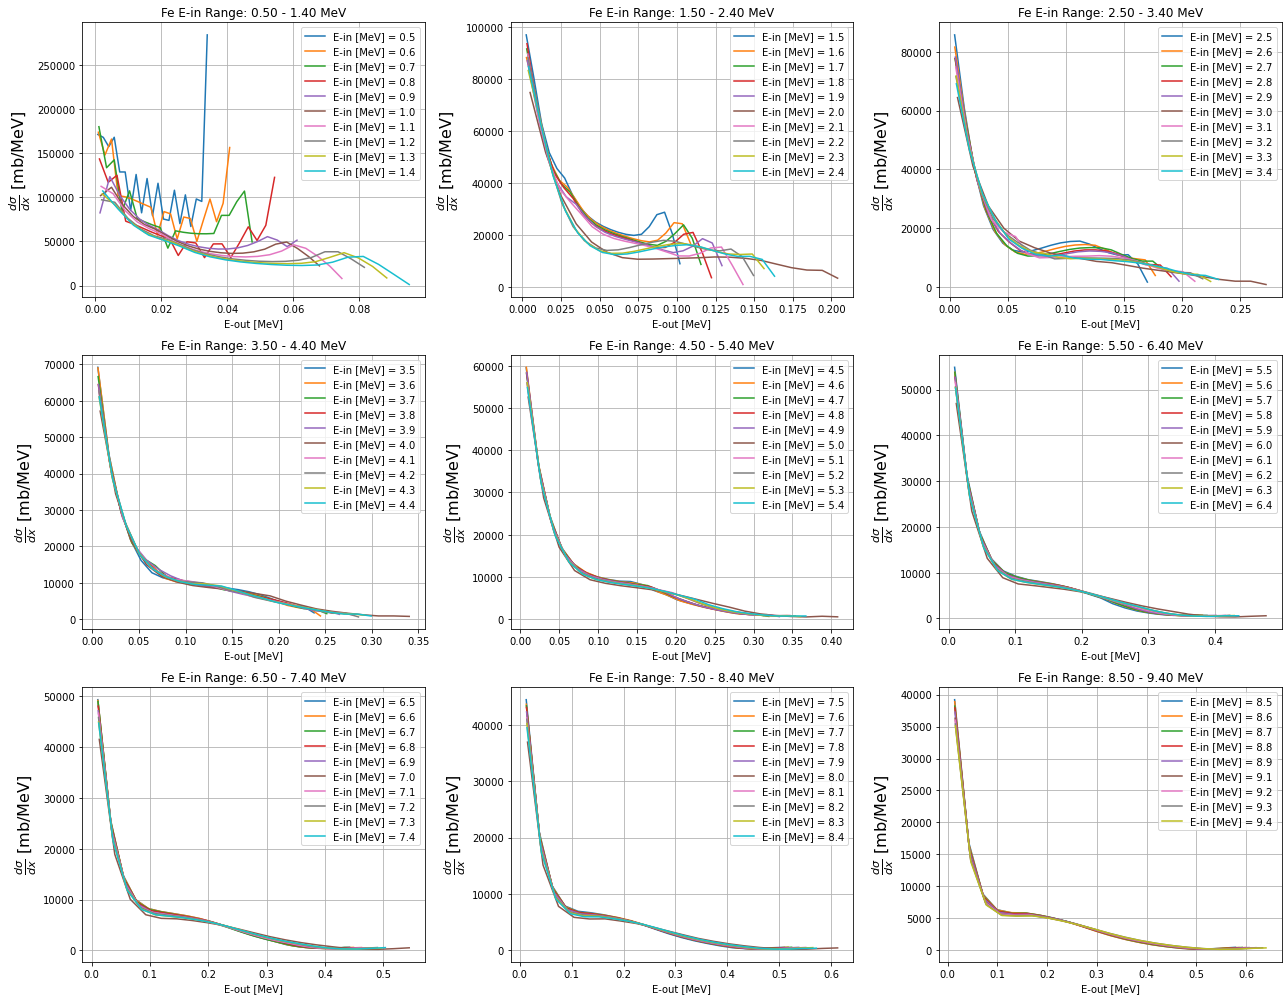

In [16]:
min_energy = min(E_initial_unique_fe)
max_energy = max(E_initial_unique_fe)

bins = np.arange(min_energy, max_energy + 1, 1)  #generating bins over proper range to cover the initial energy

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))
axes = axes.flatten()  

for i, ax in enumerate(axes):
    if i >= len(bins) - 1:
        ax.axis('off')  
        continue

    start_bin = bins[i]
    end_bin = bins[i + 1]
    
    current_chunk = [e for e in E_initial_unique_fe if start_bin <= e < end_bin] #getting data in correct energy ranges
    for e in current_chunk:
        filtered_df = combined_df_fe[combined_df_fe['E-in [MeV]'] == e]
        ax.plot(filtered_df['E-out [MeV]'], filtered_df[' xs [mb/MeV]'], label=f'E-in [MeV] = {e}')
    
    ax.set_xlabel('E-out [MeV]', fontsize=10)
    ax.set_ylabel(r'$\frac{d\sigma}{dx}$ [mb/MeV]', fontsize=16)
    ax.set_title(f'Fe E-in Range: {start_bin:.2f} - {(end_bin - 0.1):.2f} MeV')
    ax.grid(True)
    ax.legend(loc='best')


plt.tight_layout()
plt.show()

## Visualize different angular distributions for each target nuclei.

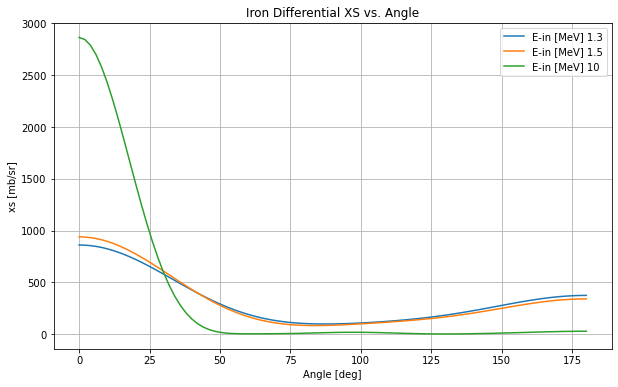

In [17]:
energy_in_mev_to_plot1 = 1.3 
energy_in_mev_to_plot2 = 1.5
energy_in_mev_to_plot3 = 10


# Filter the DataFrame for the specified E-in [MeV]
filtered_data1 = loo_fe[loo_fe['E-in [MeV]'] == energy_in_mev_to_plot1]
filtered_data2 = loo_fe[loo_fe['E-in [MeV]'] == energy_in_mev_to_plot2]
filtered_data3 = loo_fe[loo_fe['E-in [MeV]'] == energy_in_mev_to_plot3]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_data1['Angle [deg]'], filtered_data1['xs [mb/sr]'], label=f'E-in [MeV] {energy_in_mev_to_plot1}')
plt.plot(filtered_data2['Angle [deg]'], filtered_data2['xs [mb/sr]'], label=f'E-in [MeV] {energy_in_mev_to_plot2}')
plt.plot(filtered_data3['Angle [deg]'], filtered_data3['xs [mb/sr]'], label=f'E-in [MeV] {energy_in_mev_to_plot3}')


plt.xlabel('Angle [deg]')
plt.ylabel('xs [mb/sr]')
plt.title(f'Iron Differential XS vs. Angle')
plt.legend()
plt.grid()
plt.show()

# Calculating $\frac{dR}{dE}$. Recall this is the equation we want to solve: $(\frac{dR}{dE})_{T} = \frac{1}{M_{T}} \int \frac{d\sigma}{dE_{r}} \frac{d\phi}{dE_{n}} dE_{n}$

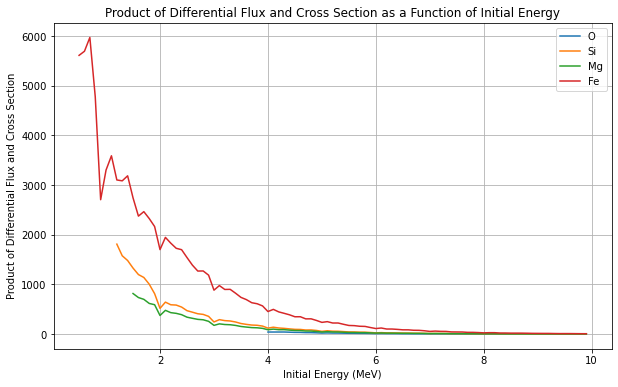

In [18]:
mass_o = 16 
mass_si = 26
mass_mg = 24
mass_fe = 56

elements = ['o', 'si', 'mg', 'fe']


#defining these as dictionaries to access within the for-loops
masses = {'o': mass_o, 'si': mass_si, 'mg': mass_mg, 'fe': mass_fe} 
E_initial_unique = {'o': E_initial_unique_o, 'si': E_initial_unique_si, 'mg': E_initial_unique_mg, 'fe': E_initial_unique_fe}
combined_df = {'o': combined_df_o, 'si': combined_df_si, 'mg': combined_df_mg, 'fe': combined_df_fe}

plt.figure(figsize=(10, 6))  # Create a new figure for plotting

for element in elements:
    # Read the correct dataframes based on the element
    df_chosen_dphi = f'loo_{element}'  # Assuming this dataframe exists
    df_chosen_dsigma = combined_df[element]  # Use combined_df dictionary

    # Lists to store differential flux and cross section values
    flux_values = []
    cross_sec_values = []

    # Loop over unique energies for this element
    for e in E_initial_unique[element]:
        for rect in rectangles:
            if rect['range'][0] <= e < rect['range'][1]:
                diff_flux_value = rect['height'] * (rect['range'][1] - rect['range'][0])
                flux_values.append(diff_flux_value)  # Store flux value
                break  # Exit once the correct rectangle is found

        # Get differential cross section value for the current energy 'e'
        filtered_df = df_chosen_dsigma[df_chosen_dsigma['E-in [MeV]'] == e]  # Filter by energy
        diff_cross_sec_value = filtered_df[' xs [mb/MeV]'].values[0]  # Assuming only one value per energy
        cross_sec_values.append(diff_cross_sec_value)  # Store cross section value

    # Convert flux and cross-section lists to numpy arrays for integration
    flux_values = np.array(flux_values)
    cross_sec_values = np.array(cross_sec_values)
    energies = np.array(E_initial_unique[element])  # Convert energy list to numpy array

    # Ensure that the lengths of flux_values, cross_sec_values, and energies are the same
    min_length = min(len(flux_values), len(cross_sec_values), len(energies))
    
    # Trim all arrays to the minimum length
    flux_values = flux_values[:min_length]
    cross_sec_values = cross_sec_values[:min_length]
    energies = energies[:min_length]

    # Multiply differential flux and cross section values
    product_values = flux_values * cross_sec_values

    # Plot product values as a function of energy
    plt.plot(energies, product_values, label=f'{element.capitalize()}')  # Plot each element's curve

# Add labels and title to the plot
plt.xlabel('Initial Energy (MeV)')
plt.ylabel('Product of Differential Flux and Cross Section')
plt.title('Product of Differential Flux and Cross Section as a Function of Initial Energy')
plt.legend()  # Show legend for the elements
plt.grid(True)  # Add grid lines for better readability
plt.show()  # Display the plot


## Doing the actual back of the hand calculation.

In [19]:
low_index = np.searchsorted(intervals, 1.5)  # Index for 1 MeV
high_index = np.searchsorted(intervals, 10)  # Index for 10 MeV

# Sum probabilities in the range [1, 10]
prob_in_range = np.sum(probabilities[low_index:high_index])
percentage_in_range = prob_in_range * 100

print(f"Percentage of particles in the range 1 to 10 MeV: {percentage_in_range:.2f}%")
#here we are finding the percentage of neutrons over say 1 MeV in the watt spectrum that would have enough energy to result in a track

Percentage of particles in the range 1 to 10 MeV: 55.54%


In [24]:
radiation_initial = 90e-6 #corresponds to initial radiation level of sample when it was first brought above ground in September 2012
mass = 1 #mass of sample of olivine in grams, since we are doing this per gram
half_life = 2.645 #in years
bec = 3.7e10

time_evolved = 12 #in years
num_half_lives = time_evolved / half_life

radioactivity = radiation_initial * ((0.5) ** (num_half_lives)) #corresponds to the current radiation level in C
radioactivity = radioactivity * bec #in decays/second
radioactivity
decays_second = 2.3e12

In [25]:
onemg252cf = 2.3e12 #this is the number for one gram of 252Cf it emits 2.3e12 neutrons per second - find how many cause tracks

neutron_rate = 0.031 #saying that 3.1% of decays from 252Cf result in spontaneous fission neutrons produced 

mit_lab_number = 6e17 #number of neutrons / m^2 * s from MIT reactor

print(f"We know that one gram of 252Cf at radioactivity {radioactivity} C is expected to emit {decays_second} neutrons per second. Let's now take this to find number of expected tracks per second per gram.")

initial_mass = 1 #in grams, the initial mass of the 252 Cf source when it was first brought above earth so need to find the updated mass - get this from Josh
neutron_cross_oxygen = 0.00028 #in barns
neutron_cross_silicon = 0.166 #in barns
neutron_cross_magnesium = 0.063 #in barns
neutron_cross_iron = 2.56 #in barns

We know that one gram of 252Cf at radioactivity 143454.0071935712 C is expected to emit 2300000000000.0 neutrons per second. Let's now take this to find number of expected tracks per second per gram.


In [ ]:
#result = flux * natoms * sigma
olivine_molar = 153.31 #mass of olivine in molar mass (g/mol)
N_atoms = (1/olivine_molar) * (6.022*10**23)

radius = 1 #in meters
flux = radioactivity / (4 * np.pi * (radius)**2) #flux for the 252Cf source

sigma_average = ( (4 * neutron_cross_oxygen) + neutron_cross_silicon + (1.8 * neutron_cross_magnesium) + (0.2 * neutron_cross_iron)) / (4 + 1 + 1.8 + 0.2) #in barns
sigma_average = sigma_average * (10e-28) #in m^2


result1 = sigma_average * N_atoms * flux
result2 = sigma_average * N_atoms * mit_lab_number
print(f"The expected number of neutrons from 252Cf to interact in our 1g sample of olivine placed a distance {radius}m away is {result1} neutrons per second per gram.")
print(f"The expected number of neutrons from the MIT nuclear reactor to interact in our 1g sample of olivine is {result2} neutrons per second per gram.")

In [ ]:
f = 1000
C = 1e-7

R = 1 / (2 * np.pi * f * C)
R

In [ ]:
N_atoms

In [ ]:
sigma_average

## Since there are too few neutron interactions with our olivine source simply using the 252Cf source available, now do the calculation for a research reactor around 4 MV again, finding the relevant neutron energy range as needed.